In [72]:
import sys
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import os

In [73]:
time_length = 1000
time_step = 0.1
inverse_time_step = 10

In [74]:
def make_cwnd_rtt(input1, input2, file_name):
    with open(file_name) as f:
        content = f.readlines()
    splitter = lambda x: x[:-1].split()
    split_input = list(map(splitter, content))
    time = list(map(lambda x: x[0], split_input))
    new_input1 = list(map(lambda x: x[1], split_input))
    new_input2 = list(map(lambda x: x[2], split_input))
    
    input1 = [float(x) + float(y) for x, y in zip(input1, new_input1)]
    input2 = [float(x) + float(y) for x, y in zip(input2, new_input2)]
    
    return input1, input2

In [77]:

def get_packet_loss(lost_packets, packets):
    packet_loss = []
    j, k = 0 ,0
    prev_i = 0
    for i in np.arange(0.0, time_length, 1):
        lost_num = 0
        packets_num = 0
        while(j < len(lost_packets) and lost_packets[j] < i):
            lost_num += 1
            j += 1
        while(k < len(packets) and packets[k] < i):
            packets_num += 1
            k += 1
        if(packets_num):
            packet_loss.append(lost_num/packets_num)
        else:
            packet_loss.append(0)
#         prev_i = i
    return packet_loss
packet_loss1 = get_packet_loss(drop_1, packet_1)
packet_loss2 = get_packet_loss(drop_2, packet_2)

In [78]:
def sum_packet_loss(prev_packet_loss1, prev_packet_loss2, filename):
    with open(filename) as f:
        content = f.readlines()
    split_drop = list(map(lambda x: x[:-1].split(), content))
    drop_data = list(map(lambda x: x if 'd' in x else None, split_drop))
    drop_data = list(filter((None).__ne__, drop_data))

    drop_1 = list(map(lambda x: float(x[1]) if x[7] == '0' else None, drop_data))
    drop_1 = list(filter((None).__ne__, drop_1))

    drop_2 = list(map(lambda x: float(x[1]) if x[7] == '1' else None, drop_data))
    drop_2 = list(filter((None).__ne__, drop_2))

#     print('drop stream 1 :', len(drop_1),' for file : ', filename)
#     print('drop stream 2 :', len(drop_2),' for file : ', filename)
    
    split_packet = list(map(lambda x: x[:-1].split(), content))
    packet_data = list(map(lambda x: x if '+' in x else None, split_packet))
    packet_data = list(filter((None).__ne__, packet_data))

    packet_1 = list(map(lambda x: float(x[1]) if x[2] == '0' and x[3] == '2' else None, packet_data))
    packet_1 = list(filter((None).__ne__, packet_1))

    packet_2 = list(map(lambda x: float(x[1]) if x[2] == '1' and x[3] == '2' else None, packet_data))
    packet_2 = list(filter((None).__ne__, packet_2))

#     print('total packets for stream 1 : ', len(packet_1), ' for file : ', filename)
#     print('total packets for stream 2 : ', len(packet_2), ' for file : ', filename)
    
    packet_loss1 = get_packet_loss(drop_1, packet_1)
    packet_loss2 = get_packet_loss(drop_2, packet_2)
    
    return [sum(x) for x in zip(packet_loss1, prev_packet_loss1)], [sum(x) for x in zip(packet_loss2, prev_packet_loss2)]

In [ ]:
reno_cwnd1 = [0] * time_length * inverse_time_step
reno_cwnd2 = [0] * time_length * inverse_time_step
tahoe_cwnd1 = [0] * time_length * inverse_time_step
tahoe_cwnd2 = [0] * time_length * inverse_time_step
vegas_cwnd1 = [0] * time_length * inverse_time_step
vegas_cwnd2 = [0] * time_length * inverse_time_step

reno_rtt1 = [0] * time_length * inverse_time_step
reno_rtt2 = [0] * time_length * inverse_time_step
tahoe_rtt1 = [0] * time_length * inverse_time_step
tahoe_rtt2 = [0] * time_length * inverse_time_step
vegas_rtt1 = [0] * time_length * inverse_time_step
vegas_rtt2 = [0] * time_length * inverse_time_step

reno_packet_loss1 = [0] * time_length 
reno_packet_loss2 = [0] * time_length
tahoe_packet_loss1 = [0] * time_length 
tahoe_packet_loss2 = [0] * time_length # in tikash kheili kasif shod vali bikhial
vegas_packet_loss1 = [0] * time_length 
vegas_packet_loss2 = [0] * time_length 

for i in range(10):
    os.system('ns reno.tcl')
    os.system('ns tahoe.tcl')
    os.system('ns vegas.tcl')
    
    reno_cwnd1, reno_cwnd2 = make_cwnd_rtt(reno_cwnd1, reno_cwnd2, 'cwnd_reno')
    tahoe_cwnd1, tahoe_cwnd2 = make_cwnd_rtt(tahoe_cwnd1, tahoe_cwnd2, 'cwnd_tahoe')
    vegas_cwnd1, vegas_cwnd2 = make_cwnd_rtt(vegas_cwnd1, vegas_cwnd2, 'cwnd_vegas')
    
    reno_rtt1, reno_rtt2 = make_cwnd_rtt(reno_rtt1, reno_rtt2, 'rtt_reno')
    tahoe_rtt1, tahoe_rtt2 = make_cwnd_rtt(tahoe_rtt1, tahoe_rtt2, 'rtt_tahoe')
    vegas_rtt1, vegas_rtt2 = make_cwnd_rtt(vegas_rtt1, vegas_rtt2, 'rtt_vegas')
    
    reno_packet_loss1, reno_packet_loss2 = sum_packet_loss(reno_packet_loss1, 
                                                           reno_packet_loss2, 'trace_reno.tr')
    tahoe_packet_loss1, tahoe_packet_loss2 = sum_packet_loss(tahoe_packet_loss1, 
                                                             tahoe_packet_loss2, 'trace_tahoe.tr')
    vegas_packet_loss1, vegas_packet_loss2 = sum_packet_loss(vegas_packet_loss1,
                                                             vegas_packet_loss2, 'trace_vegas.tr')

reno_cwnd1 = [x / 10 for x in reno_cwnd1]  
tahoe_cwnd1 = [x / 10 for x in tahoe_cwnd1] 
vegas_cwnd1 = [x / 10 for x in vegas_cwnd1] 
reno_cwnd2 = [x / 10 for x in reno_cwnd2]  
tahoe_cwnd2 = [x / 10 for x in tahoe_cwnd2] 
vegas_cwnd2 = [x / 10 for x in vegas_cwnd2] 

reno_rtt1 = [x / 10 for x in reno_rtt1]
tahoe_rtt1 = [x / 10 for x in tahoe_rtt1]
vegas_rtt1 = [x / 10 for x in vegas_rtt1]
reno_rtt2 = [x / 10 for x in reno_rtt2]
tahoe_rtt2 = [x / 10 for x in tahoe_rtt2]
vegas_rtt2 = [x / 10 for x in vegas_rtt2]

reno_packet_loss1 = [x/10 for x in reno_packet_loss1]
tahoe_packet_loss1 = [x/10 for x in tahoe_packet_loss1]
vegas_packet_loss1 = [x/10 for x in vegas_packet_loss1]
reno_packet_loss2 = [x/10 for x in reno_packet_loss2]
tahoe_packet_loss2 = [x/10 for x in tahoe_packet_loss2]
vegas_packet_loss2 = [x/10 for x in vegas_packet_loss2]


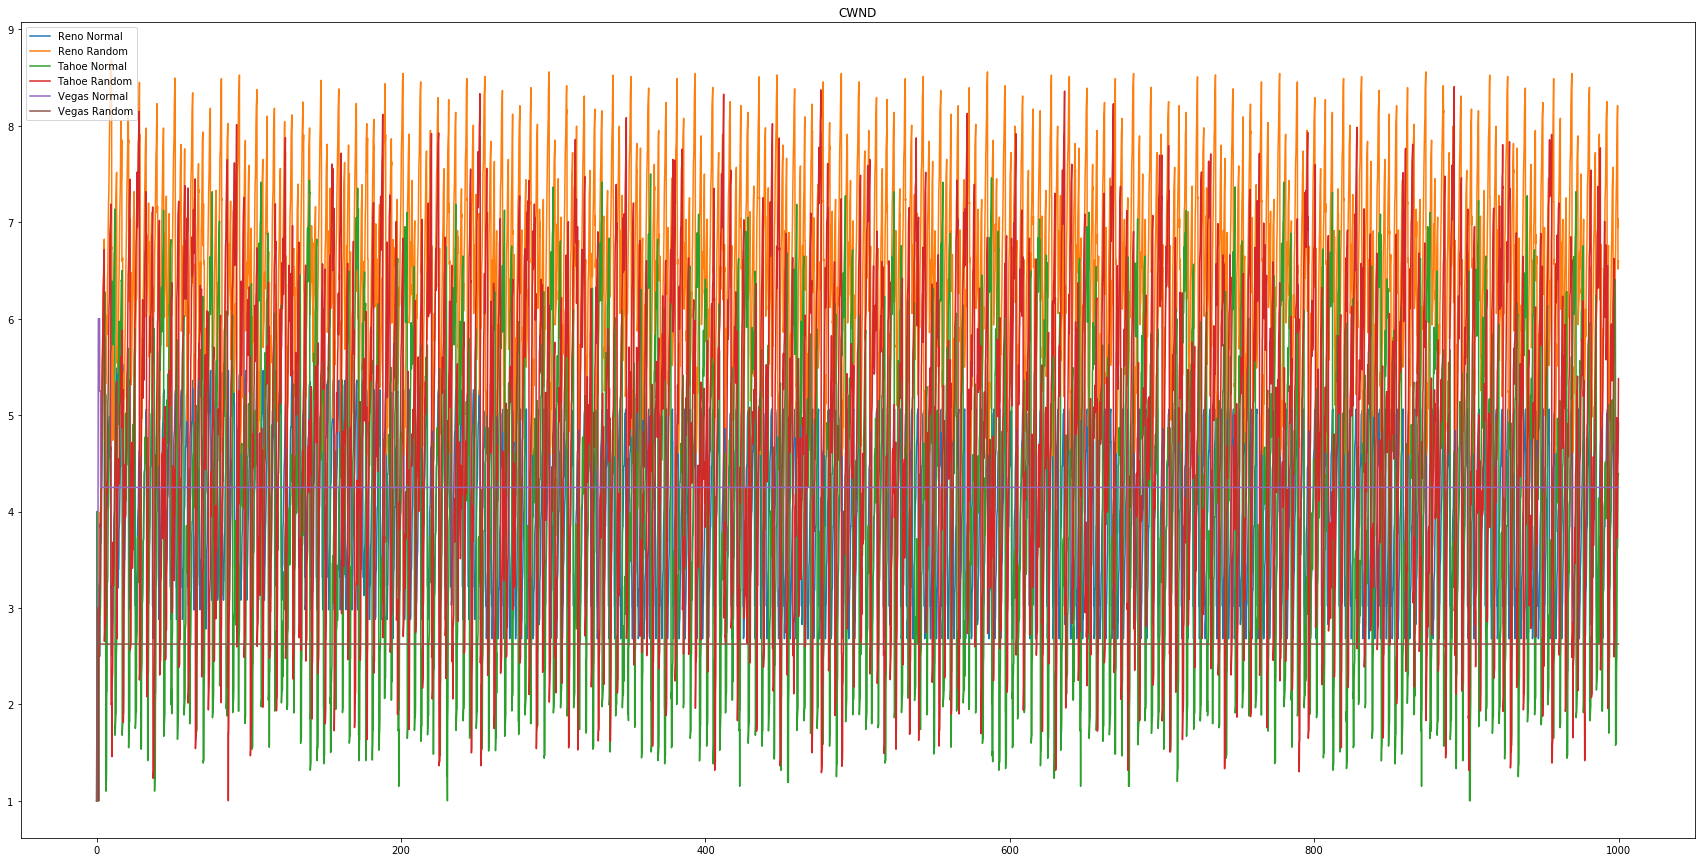

In [69]:
plt.figure(figsize=(30,15))
plt.plot(np.arange(0, time_length, time_step), reno_cwnd1)
plt.plot(np.arange(0, time_length, time_step), reno_cwnd2)
plt.plot(np.arange(0, time_length, time_step), tahoe_cwnd1)
plt.plot(np.arange(0, time_length, time_step), tahoe_cwnd2)
plt.plot(np.arange(0, time_length, time_step), vegas_cwnd1)
plt.plot(np.arange(0, time_length, time_step), vegas_cwnd2)
plt.legend(['Reno Normal', 'Reno Random','Tahoe Normal', 'Tahoe Random',
           'Vegas Normal', 'Vegas Random'], loc='upper left')
plt.title('CWND')
plt.show()

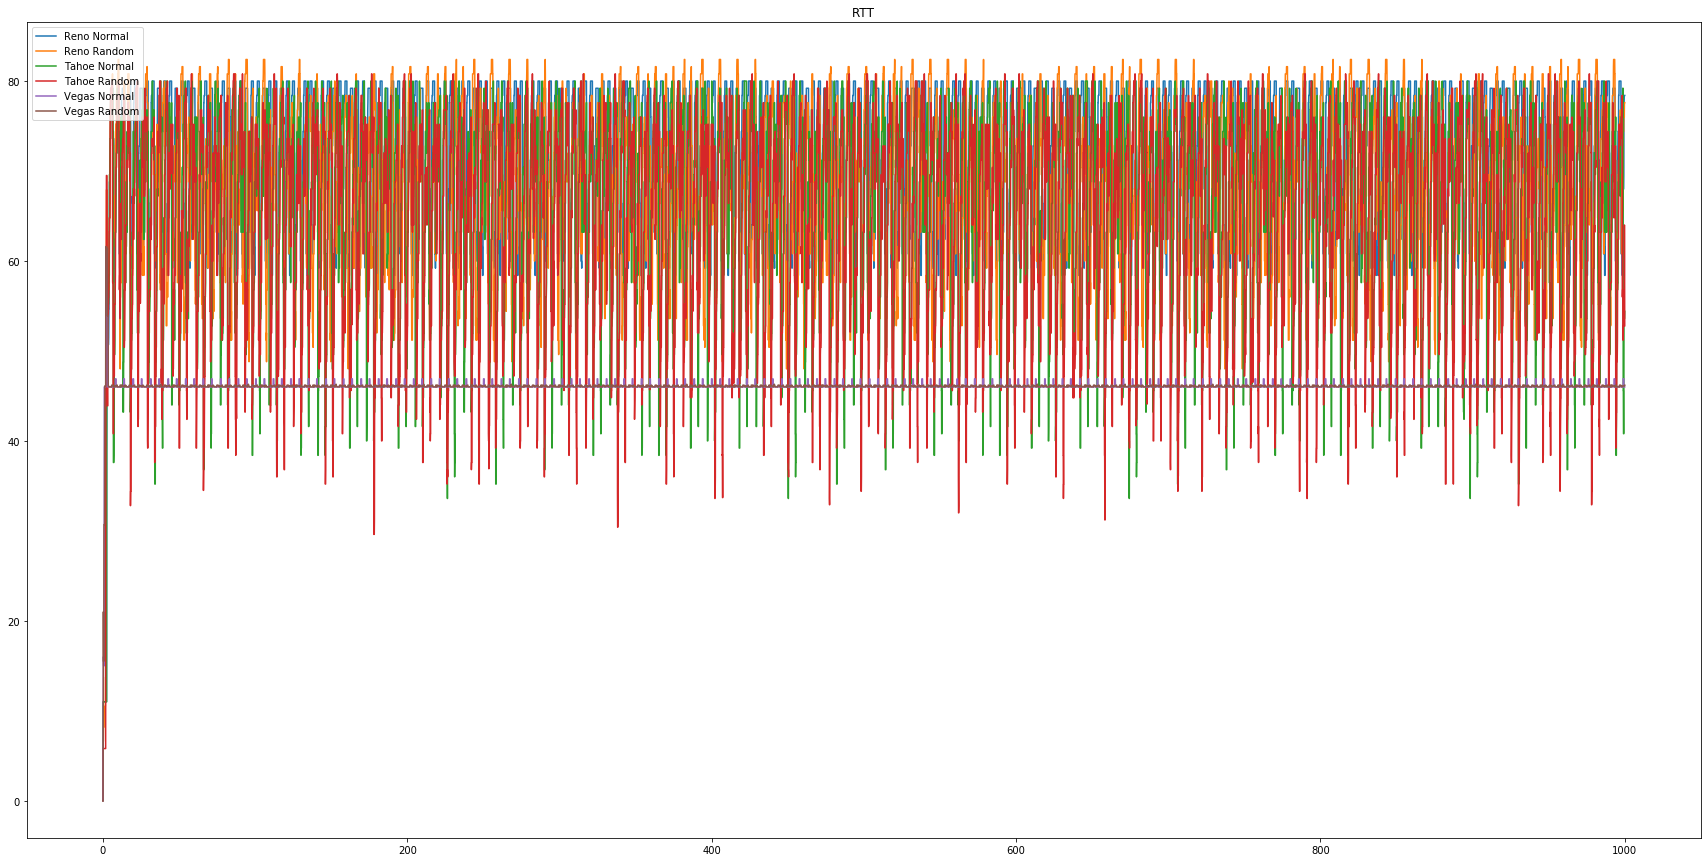

In [70]:
plt.figure(figsize=(30,15))
plt.plot(np.arange(0, time_length, 0.1), reno_rtt1)
plt.plot(np.arange(0, time_length, 0.1), reno_rtt2)
plt.plot(np.arange(0, time_length, 0.1), tahoe_rtt1)
plt.plot(np.arange(0, time_length, 0.1), tahoe_rtt2)
plt.plot(np.arange(0, time_length, 0.1), vegas_rtt1)
plt.plot(np.arange(0, time_length, 0.1), vegas_rtt2)
plt.legend(['Reno Normal', 'Reno Random', 'Tahoe Normal', 'Tahoe Random',
           'Vegas Normal', 'Vegas Random'], loc='upper left')
plt.title('RTT')
plt.show()

ValueError: x and y must have same first dimension, but have shapes (1000,) and (100,)

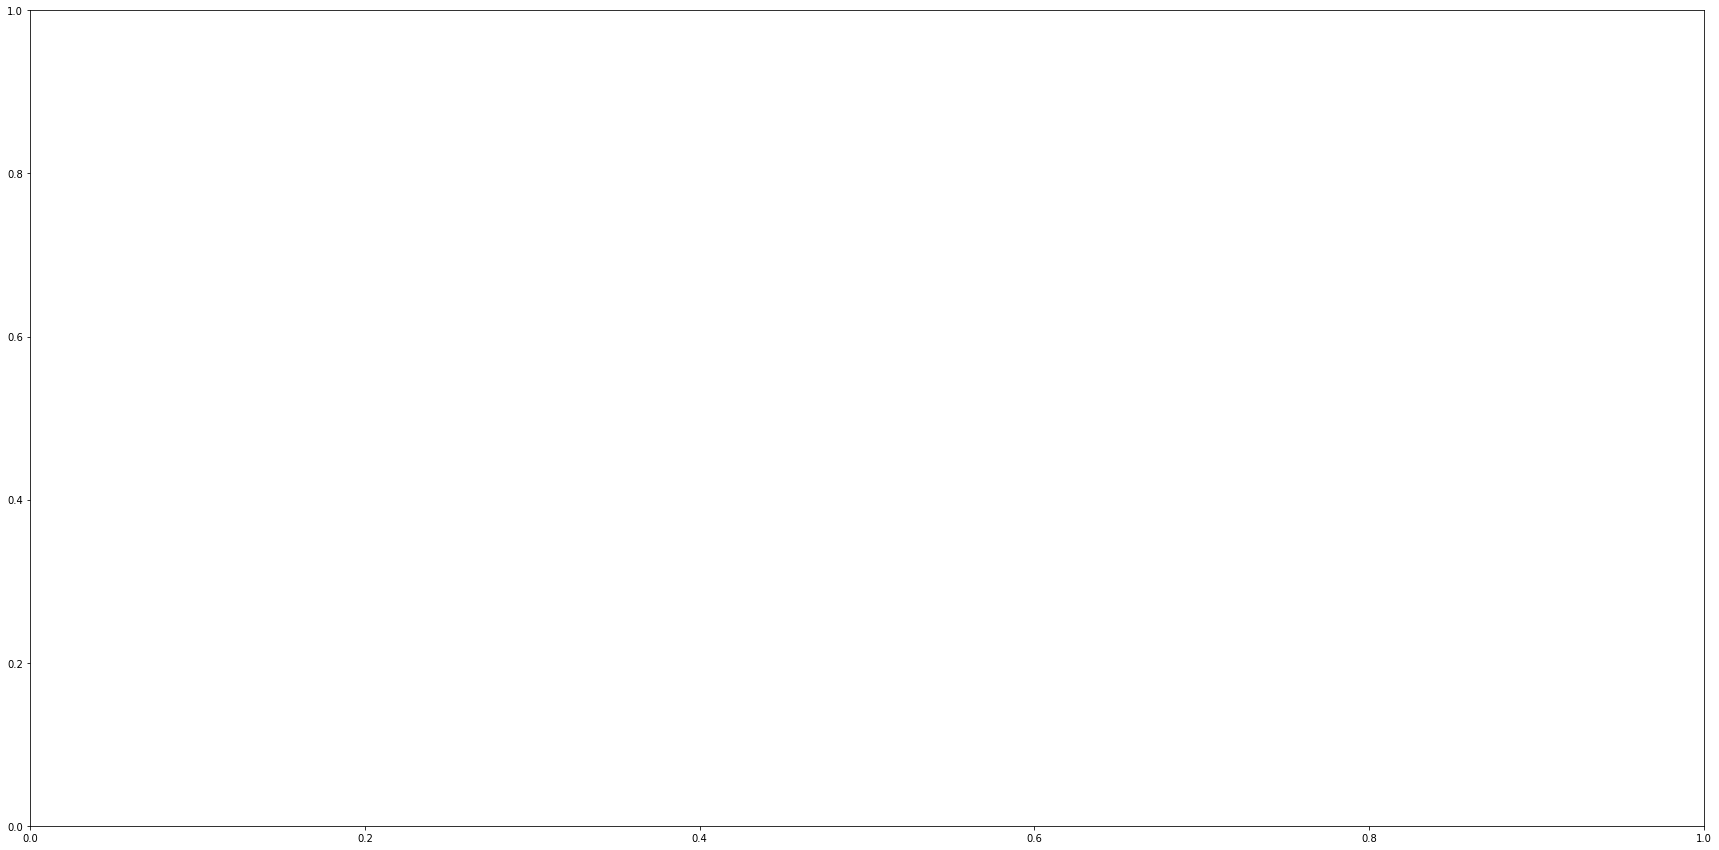

In [71]:
plt.figure(figsize=(30,15))
plt.plot(np.arange(time_length), reno_packet_loss1)
plt.plot(np.arange(time_length), reno_packet_loss2)
plt.plot(np.arange(time_length), tahoe_packet_loss1)
plt.plot(np.arange(time_length), tahoe_packet_loss2)
plt.plot(np.arange(time_length), vegas_packet_loss1)
plt.plot(np.arange(time_length), vegas_packet_loss2)

plt.legend(['Reno Normal', 'Reno Random', 'Tahoe Normal', 'Tahoe Random',
           'Vegas Normal', 'Vegas Random'], loc='upper left')
plt.title('Packet Loss')
plt.show()
# len(packet_loss2)

In [10]:
filename = 'trace.tr'
with open(filename) as f:
    content = f.readlines()
split_received = list(map(lambda x: x[:-1].split(), content))
received_data = list(map(lambda x: x if x[0] == 'r' else None, split_received))
received_data = list(filter((None).__ne__, received_data))

received_1 = list(map(lambda x: float(x[1]) if x[2] == '3' and x[3] == '4' else None, received_data))
received_1 = list(filter((None).__ne__, received_1))

received_2 = list(map(lambda x: float(x[1]) if x[2] == '3' and x[3] == '5' else None, received_data))
received_2 = list(filter((None).__ne__, received_2))

# print((received_1))

In [11]:
def get_goodput(received, loss):
    goodput = list()
    received_idx = 0
    loss_idx = 0
    loss_ended = False

    for t in range(1, 101):
        t_goodput = 0
        while (not loss_ended) and (loss_idx < len(loss) and loss[loss_idx] < t - 1):
            loss_idx += 1
        if loss_idx == len(loss) and received[received_idx] >= loss[loss_idx-1]:
            loss_ended = True
            loss_idx -= 1
            
        while received_idx < len(received) and received[received_idx] < t - 1:
            received_idx += 1
            
        while received_idx < len(received) and (loss_ended or received[received_idx] < loss[loss_idx]) and received[received_idx] < t :
            t_goodput += 1
            received_idx += 1
        goodput.append(t_goodput * 1000 * 8)
        
    return goodput

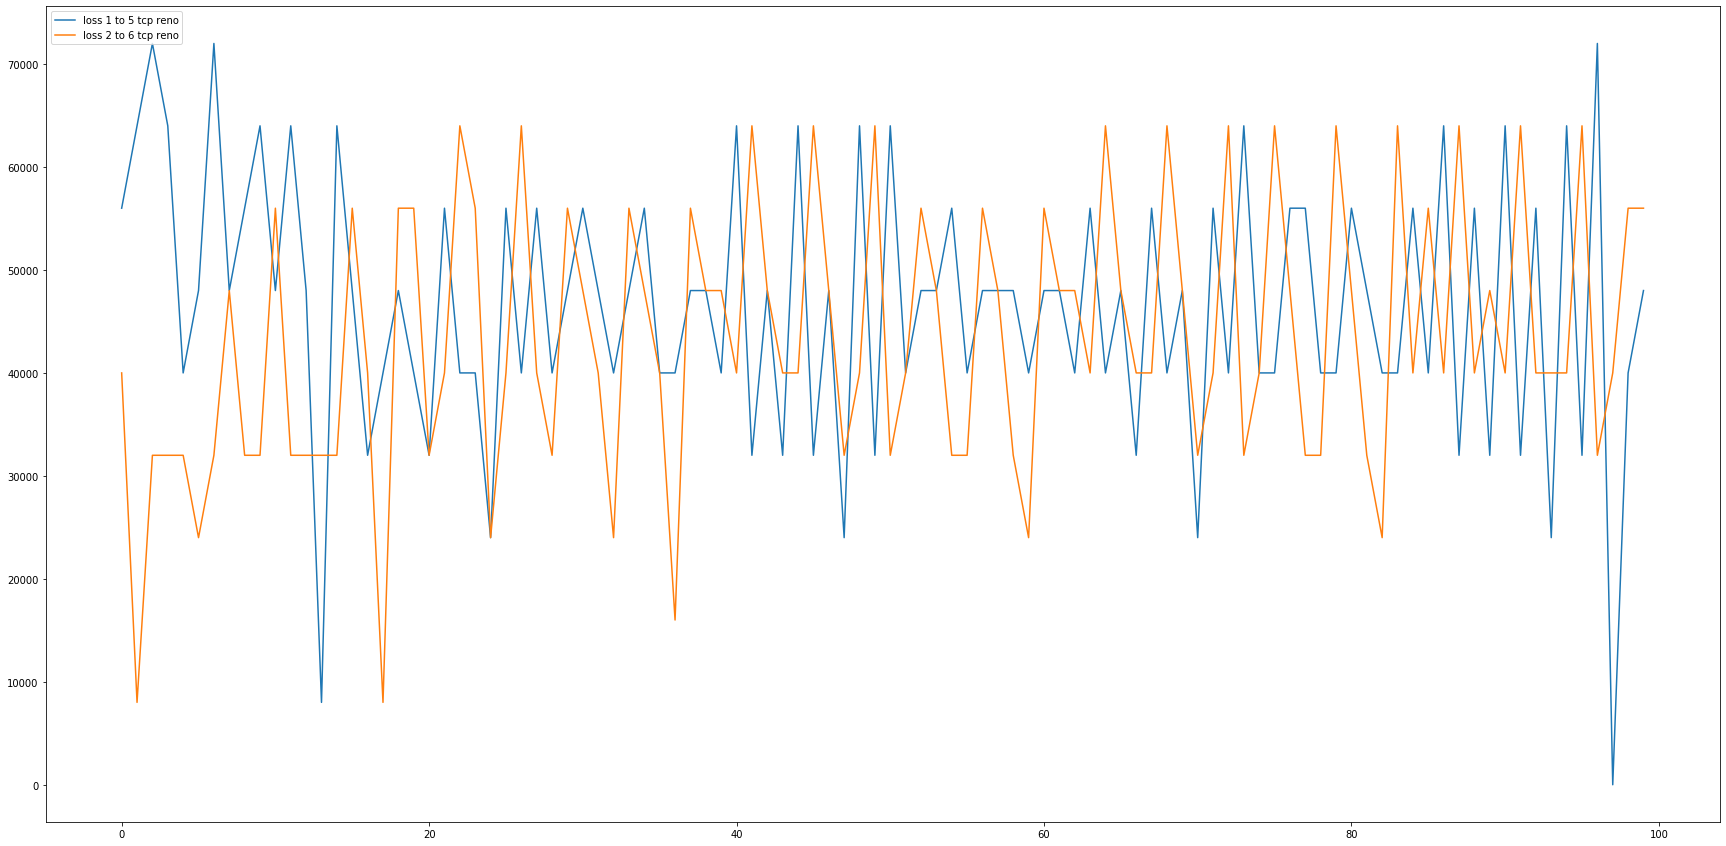

In [12]:
goodput_1 = get_goodput(received_1, drop_1)
goodput_2 = get_goodput(received_2, drop_2)

plt.figure(figsize=(30,15))
plt.plot(np.arange(100), goodput_1)
plt.plot(np.arange(100), goodput_2)
plt.legend(['loss 1 to 5 tcp reno', 'loss 2 to 6 tcp reno'], loc='upper left')
plt.show()